
Finetuning Torchvision Models
=============================
* tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html (https://cs231n.github.io/transfer-learning)
* models: https://pytorch.org/vision/stable/models.html
* datasets: https://pytorch.org/vision/stable/datasets.html

TODO: try image size > 224: https://discuss.pytorch.org/t/transfer-learning-usage-with-different-input-size/20744/6

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
#from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import time
from PIL import Image

%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.5.1+cu124
Torchvision Version:  0.20.1+cu124


In [15]:
# Helper Functions
from libs.model_definitions import initialize_model
from libs.train_model import train_model

## Settings

In [16]:
# data directory with [train, val, test] dirs
data_dir = "./dataset/"

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# number of data loader workers
dloader_workers = 6

# Number of classes in the dataset
num_classes = 4   # TODO: len(image_datasets['train'].classes) or from folders


model_list =    ["resnet18", "resnet50", "alexnet", "vgg11_bn", "squeezenet", "densenet121", "inception_v3", "mobilenet_v2", 
                "mobilenet_v3_large", "regnet_y_16gf", "efficientnet_v2_s", "efficientnet_v2_m", "convnext_base", "swin_v2_b"]

model_type = "mobilenet_v3_large"

model_name = "mobilenet_v3_large"
checkpoints_dir = "checkpoints/"
checkpoint_path = os.path.join(checkpoints_dir, model_name + ".pt")

add_softmax = False

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 12

learning_rate = 1e-4

# train all layers or just head layer
train_deep = True

# check if model_type exists
if not model_type in model_list:
    print(f"ERROR: model {model_type} unknown!")

----------------
# Training

## Helper Functions

initialize model:

In [17]:
# Initialize the model for this run
model, input_size = initialize_model(model_type, num_classes, train_deep, add_softmax=add_softmax)

### time helper

In [18]:
def get_current_date():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

### JSON helper

In [19]:
# write model metadata to json file
def save_json(data, dirpath, model_name, update=True):
    jsonpath = os.path.join(dirpath, model_name + "_metadata.json")

    if update:
        with open(jsonpath) as f:
            data_old = json.load(f)
        data_old.update(data)
        data = data_old
    
    with open(jsonpath, 'w') as f:
        json.dump(data, f)

## Load Data
----------------
Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dloader_workers) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print("class_names:", class_names)

Initializing Datasets and Dataloaders...
class_names: ['ants', 'bees', 'cats', 'dogs']


In [21]:
def visualize_model(model, device=device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_labels = torch.max(probabilities, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[top_labels[j]]
                predicted_prob = top_probs[j].cpu().numpy()
                ax.set_title(f'predicted: {predicted_class} ({predicted_prob:.2f})')

                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean  # denormalize
                img = np.clip(img, 0, 1)

                plt.imshow(img)
            
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``train_deep=False`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.

--------------------
using Adam instead of SGD:  
https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/


In [22]:
# Send the model to GPU if possible
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
#print("Params to learn:")
if not train_deep:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


## Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [23]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

starttime = time.time()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, device=device)

training_duration = time.time() - starttime

Epoch 0/11
----------
train Loss: 1.0204 Acc: 0.6760
val Loss: 0.5562 Acc: 0.9571

Epoch 1/11
----------
train Loss: 0.4499 Acc: 0.8680
val Loss: 0.1685 Acc: 0.9657

Epoch 2/11
----------
train Loss: 0.2477 Acc: 0.9100
val Loss: 0.1258 Acc: 0.9614

Epoch 3/11
----------
train Loss: 0.1570 Acc: 0.9480
val Loss: 0.1176 Acc: 0.9700

Epoch 4/11
----------
train Loss: 0.2093 Acc: 0.9220
val Loss: 0.1035 Acc: 0.9700

Epoch 5/11
----------
train Loss: 0.1176 Acc: 0.9600
val Loss: 0.1220 Acc: 0.9485

Epoch 6/11
----------
train Loss: 0.0994 Acc: 0.9680
val Loss: 0.1260 Acc: 0.9528

Epoch 7/11
----------
train Loss: 0.0998 Acc: 0.9520
val Loss: 0.1409 Acc: 0.9399

Epoch 8/11
----------
train Loss: 0.0880 Acc: 0.9680
val Loss: 0.1083 Acc: 0.9442

Epoch 9/11
----------
train Loss: 0.1088 Acc: 0.9560
val Loss: 0.1259 Acc: 0.9485

Epoch 10/11
----------
train Loss: 0.0978 Acc: 0.9740
val Loss: 0.1312 Acc: 0.9657

Epoch 11/11
----------
train Loss: 0.0861 Acc: 0.9680
val Loss: 0.1319 Acc: 0.9614

Tr

In [24]:
best_val_acc = round(float(max(hist)), 4)
last_val_acc = round(float(hist[-1]), 4)

print("best_val_acc:", best_val_acc)
print("last_val_acc:", last_val_acc)

best_val_acc: 0.97
last_val_acc: 0.9614


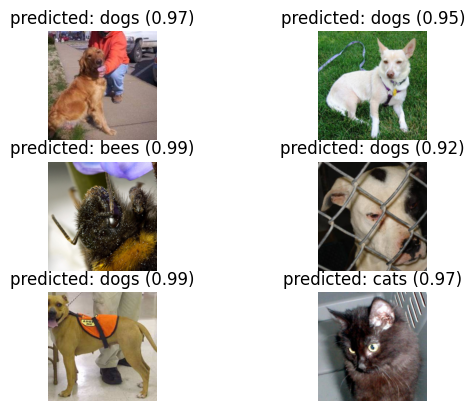

In [25]:
visualize_model(model, device=device)

## Save Checkpoint
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

In [26]:
# EPOCH = num_epochs  # TODO: current epoch / epoch of best val acc
# LOSS = 0.4          # TODO read from hist
#
# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict(),
#             'loss': LOSS,
#             }, checkpoint_path)

torch.save(model, checkpoint_path)


# Write variables to a JSON file
data = {
    'date_created':             get_current_date(),
    'model_type':               model_type, 
    'input_size':               input_size,
    'has_softmax':              add_softmax,
    'class_names':              class_names, 
    'initial_learning_rate':    learning_rate,
    'epochs':                   num_epochs,
    'training_time':            training_duration,
    'best_val_acc':             best_val_acc,
    'last_val_acc':             last_val_acc
    }

save_json(data, checkpoints_dir, model_name, update=False)

----------------
# Test

### Load Checkpoint

https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# # Remember to first initialize the model and optimizer, then load the dictionary locally.
# model, input_size = initialize_model(model_type, num_classes, train_deep)
# model = model.to(torch.device(device))

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


model = torch.load(checkpoint_path)
model = model.to(torch.device(device))

# set dropout and batch normalization layers to evaluation mode before running inference
model.eval()


# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

C:\temp\ipykernel_8356\3297337791.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(checkpoint_path)


In [28]:
test_dir = os.path.join(data_dir, "test")

testset = datasets.ImageFolder(test_dir, test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)

        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_acc += torch.mean(correct.float())

testimage_count = len(testset)
test_result = test_acc.item()/len(test_loader)
print(f'Accuracy of the network on {testimage_count} test images: {round(test_result * 100.0, 2)}%')


Accuracy of the network on 80 test images: 95.31%


In [29]:
# update metadata with test accuracy
data = {'date_modified': get_current_date(), 'test_acc': round(test_result, 2)}
save_json(data, checkpoints_dir, model_name, update=True)

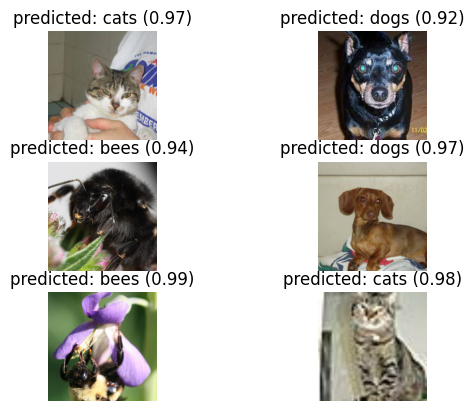

In [30]:
visualize_model(model, device=device, num_images=6)

--------------------
# Predict a single image

Predicted class: bees (0.99)


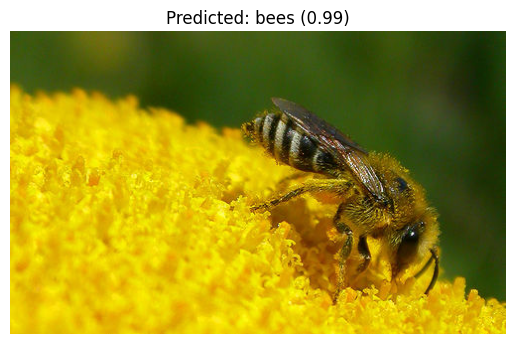

In [31]:
def predict_image(image_path, model, class_names):
    image = Image.open(image_path).convert('RGB')
    image_transformed = test_transform(image)  # Apply the transformations
    image_transformed = image_transformed.unsqueeze(0)  # Add a batch dimension
    image_transformed = image_transformed.to(device)  # Move the image to the device (GPU or CPU)
    model.eval()  # Set the model to evaluation mode
    
    
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(image_transformed)
        
        # Get the predicted class and probability
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)
        
        # Get the predicted class name and probability
        predicted_class = class_names[top_class[0][0]]
        predicted_prob = top_prob[0][0].item()
    
    return predicted_class, predicted_prob, image


# image_path = "dataset/val/ants/11381045_b352a47d8c.jpg"
image_path = "dataset/val/bees/26589803_5ba7000313.jpg"

predicted_class, predicted_prob, image = predict_image(image_path, model, class_names)
print(f'Predicted class: {predicted_class} ({predicted_prob:.2f})')

# Display the image and prediction
plt.imshow(np.array(image))
plt.title(f'Predicted: {predicted_class} ({predicted_prob:.2f})')
plt.axis('off')
plt.show()